SDP relaxation of max-cut of graph $G = (V, E)$

Primal:
$$\max \frac14 \langle L, X \rangle \quad X \succeq 0, X_{ii} = 1$$ 


$L = D - A$ is laplacian of $G$, and $D$ is the diagonal degree matrix.

Dual:
$$\min \frac14{\bf 1}^Ty \quad diag(y) - L \succeq 0$$ 


Using the change of variables $y = t {\bf 1} -u$, where $u \perp {\bf 1}$, we can write the dual as an eigenvalue problem 

$$\frac n4 \min \lambda_\max(L + diag(u)) \quad {\bf 1}^Tu = 0$$

In [2]:
import cupy as cp
import time
import numpy as np
import picos as pic
import matplotlib.pyplot as plt
from scipy.io import mmread

### Numpy and CPU
s = time.time()
x_cpu = np.ones((1000,1000,500))
e = time.time()
print(e - s)### CuPy and GPU
s = time.time()
x_gpu = cp.ones((1000,1000,500))
cp.cuda.Stream.null.synchronize()
e = time.time()
print(e - s)

0.3605363368988037
0.22232270240783691


In [103]:
# n = 200
# p = 0.5
# A = np.random.rand(n, n) > p
# A = A | A.T
# for i in range(n): 
#     A[i, i] = 0
A = mmread('graphs/C1000-9.mtx')
n = A.shape[0]
show(n)
D = np.diag(np.sum(A, axis=int(0)))
L = (D - A)#.astype(float)
L = np.array(L)
L

1000

array([[893., 892., 892., ..., 892., 892., 893.],
       [892., 893., 892., ..., 892., 892., 892.],
       [892., 892., 893., ..., 892., 892., 892.],
       ...,
       [892., 892., 892., ..., 893., 892., 892.],
       [892., 892., 892., ..., 892., 893., 892.],
       [893., 892., 892., ..., 892., 892., 893.]])

In [73]:
def picos_solve_maxcut(L, solver, verbosity):
    maxcut_problem = pic.Problem()

    # Parameter
    L_param = pic.Constant("L", L, shape=(n, n))

    # Variables
    X = pic.SymmetricVariable("X", shape=int(n))


    ## Objective
    maxcut_problem.set_objective('max', float(1/4.) * (L|X))

    ## Constraints
    # X psd
    maxcut_problem.add_constraint(X >> int(0))
    # 1 on the diagonal
    maxcut_problem.add_constraint(pic.maindiag(X) == int(1))

    if verbosity:
        print(maxcut_problem)

    maxcut_problem.solve(solver=solver, verbosity=verbosity)
    
    return maxcut_problem.value

y_base = picos_solve_maxcut(L, "mosek", 1)
show(y_base)

----------------------------------
Semidefinite Program
  maximize 0.25·⟨[1000×1000], X⟩
  over
    1000×1000 symmetric variable X
  subject to
    X ≽ 0
    maindiag(X) = [1]
----------------------------------
            PICOS 2.0.8            
Problem type: Semidefinite Program.
Searching a solution strategy for MOSEK (Optimizer).
Solution strategy:
  1. ExtraOptions
  2. MOSEKSolver
Applying ExtraOptions.
Building a MOSEK (Optimizer) problem instance.
Starting solution search.
-----------------------------------
      MOSEK via Optimizer API      
-----------------------------------
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 501500          
  Cones                  : 0               
  Scalar variables       : 500500          
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.


/home/bachir/Dev/sagemath/SageMath/local/lib/python3.7/site-packages/picos/solvers/solver_mosek.py:599: DeprecationWarning: Problem.verbosity is deprecated: Use Problem.options instead.
  self.int.putintparam(mosek.iparam.log, self.ext.verbosity())


Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.06            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.36    
MOSEK error 1051: Out of space.
Optimizer terminated. Time: 1.52    



Error: rescode.err_space(1051): Out of space.

# First order method for solving $\min_{x \in Q} \lambda_\max(A(x)) + c^Tx$

For $t=1,\ldots$, set $x_{t+1} = P_Q(x_t - \gamma \partial \lambda_\max(A(x))$.

Here, $x = u$, $Q = \{u \; {\bf 1}^T u = 0$, $A(u) = L + diag(u)$, $P_Q(u) = u - {\bf 1}^Tu$.

In [219]:
class MaxCutSubGradientSolverGPU:
    def __init__(self, L, step_size, num_steps, eig_method):
        self.L = cp.array(L)
        self.n = L.shape[0]
        self.step_size = float(step_size)
        self.num_steps = num_steps
        self.eig_method = eig_method
        
        self.x0 = cp.random.randn(n)
        self.num_power_iterations = 100
        
    def projection_Q(self, u):
        return u - cp.mean(u)

    def Au(self, u):
        return cp.diag(u) + self.L

    def objective_value(self, u):
        return float(self.n/float(4)) * self.lambda_max(self.Au(u))

    def lambda_max(self, A):
        return cp.max(cp.linalg.eigenvalue.eigvalsh(A))

    def top_eigenvec(self, A):
        
#         vals, vecs = cp.linalg.eigh(A)
#         idx = int(cp.argmax(vals))
#         top_eigvec = vecs[:, idx]
        x = self.x0
        for _ in range(self.num_power_iterations):
            x = A @ x
            x /= cp.linalg.norm(x)
        return x


    def diff_lambda_max(self, A):
        top_eigvec = self.top_eigenvec(A)
        return top_eigvec**float(2.)


    def __call__(self, u_0):
        u = cp.array(u_0)
        obj_value_history = []

        for i in range(self.num_steps):
            if i % 10 == 0:
                obj_value_history.append(float(cp.asnumpy(self.objective_value(u))))            
            u_next = u - self.step_size * self.diff_lambda_max(self.Au(u))
            u = self.projection_Q(u_next)
#             print(i, u[:3])
#             print(self.step_size)
#             print(self.diff_lambda_max(self.Au(u))[:3])
        return obj_value_history


CPU times: user 19min 5s, sys: 1min 37s, total: 20min 42s
Wall time: 20min 45s


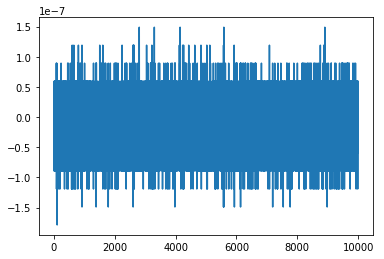

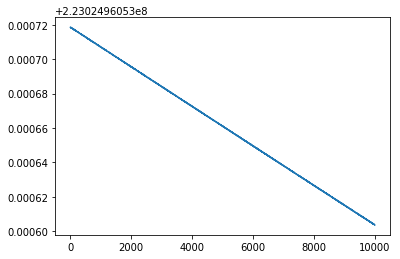

In [233]:
%%time

np.random.seed(1)
u_0 = np.random.randn(n)
solver = MaxCutSubGradientSolverGPU(L,
    step_size = 10.,
    num_steps = 100000,
    eig_method = 'gpu',)
solver.num_power_iterations = 100
#y_base = picos_solve_maxcut(L, "cvxopt", 0)
history  = np.array(solver(u_0)) 


plt.plot(np.diff(history[1:]))
#plt.yscale('symlog')
plt.figure()
plt.plot(history[1:])


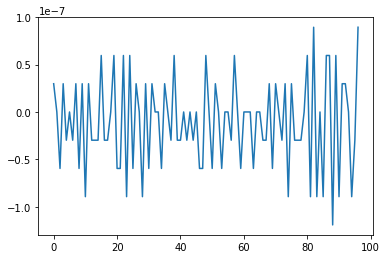

In [230]:
plt.plot(np.diff(history[2:]))


In [147]:
class MaxCutSubGradientSolver:
    def __init__(self, L, step_size, num_steps, eig_method):
        self.L = L
        self.n = L.shape[0]
        self.step_size = step_size
        self.num_steps = num_steps
        self.eig_method = eig_method
        self.num_powers = 10
        
    def projection_Q(self, u):
        return np.array(u) - np.mean(u)

    def Au(self, u):
        return np.diag(u) + self.L

    def objective_value(self, u):
        return float(self.n/float(4.)) * self.lambda_max(self.Au(u))

    def lambda_max(self, A):
        return float(cp.asnumpy(cp.max(cp.linalg.eigenvalue.eigvalsh(cp.array(A)))))

    
    def top_eigenvec(self, A):
        if self.eig_method == 'gpu':
            A = cp.asarray(A)
            vals, vecs = cp.linalg.eigh(A)
            idx = int(cp.argmax(vals))
            top_eigvec = vecs[:, idx]
            top_eigvec = cp.asnumpy(top_eigvec)
        else:
            vals, vecs = np.linalg.eig(A)
            idx = np.argmax(vals)
            top_eigvec = vecs[:, idx]
        return top_eigvec


    def top_eigenvec_powermethod(self, A):
        x = np.random.randn(A.shape[0])
        for _ in range(self.num_powers):
            x = A@x
            x /= np.linalg.norm(x)
        return x


    def diff_lambda_max(self, A):
        if self.eig_method == 'power':
            top_eigvec = self.top_eigenvec_powermethod(A)
        else:
            top_eigvec = self.top_eigenvec(A)
        return top_eigvec**2


    def __call__(self, u_0):
        u = u_0
        obj_value_history = []

        for _ in range(self.num_steps):
            obj_value_history.append(self.objective_value(u))
            u = self.projection_Q(u - self.step_size * self.diff_lambda_max(self.Au(u)))

        return obj_value_history


In [158]:
%%time

np.random.seed(1)
u_0 = np.random.randn(n)
solver = MaxCutSubGradientSolverGPU(L,
    step_size = 1e3,
    num_steps = 100,
    eig_method = 'gpu',)
solver.num_powers = 10
#y_base = picos_solve_maxcut(L, "cvxopt", 0)
history  = np.array(solver(u_0)) 
plt.plot(history)
#plt.axhline(y_base ,ls='--', c='r')
# plt.yscale('log')
#plt.ylim(y_base, 1.00001*y_base)
print("{:.2f}%".format( (history[-1]/y_base - 1) * 100))
print(history[-1], ' - ', y_base)

TypeError: Unsupported type <class 'numpy.ndarray'>

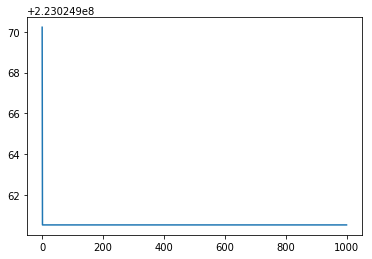

In [85]:
plt.plot(history)


In [82]:
projection_Q(projection_Q(u_0))

array([23.51824853, 22.15435339, 22.73293417, 23.99508938, 23.62175417])

In [71]:
u_0 = np.random.randn(n)
Au = lambda u: np.diag(u) + L
diff_lambda_max(Au(u_0))

array([0.00154775, 0.05340828, 0.00517162, 0.17716409, 0.76270826])

In [74]:
e = np.eye(n)
eps = 1e-4
[(lambda_max(Au(u_0 + eps*e[:, i])) - lambda_max(Au(u_0))) / eps for i in range(n)]

[0.0015478018955406014,
 0.05341004553294226,
 0.005171942367709903,
 0.1771739348388479,
 0.7627179209190871]

In [72]:
u_0 + e[:, 0]

array([-0.45436567,  0.04575852, -0.18718385,  1.53277921,  1.46935877])

In [ ]:
def projection_Q(u):
    return np.array(u) - np.mean(u)

def Au(u):
    return np.diag(u) + L
    
def objective_value(u):
    return n/4 * lambda_max(Au(u))
    
def lambda_max(A):
    return max(np.linalg.eigvalsh(A))

def top_eigenvec(A):
    vals, vecs = np.linalg.eig(A)
    idx = np.argmax(vals)
    top_eigvec = vecs[:, idx]
    return top_eigvec

def diff_lambda_max(A):
    top_eigvec = top_eigenvec(A)
    return top_eigvec**2
    
    

def subgradient_method(u_0, step_size, num_steps):
    u = u_0
    obj_value_history = []
    
    for _ in range(num_steps):
        obj_value_history.append(Au(u))
        u = projection_Q(u - step_size * diff_lambda_max(Au(u)))
    
    return obj_value_history

np.random.seed(0)
u_0 = np.random.randn(n)
step_size = 1.
num_steps = 10
y_base = picos_solve_maxcut(L, "cvxopt", 0)
plt.plot(np.array(subgradient_method(u_0, step_size, num_steps)) - y_base)
plt.yscale('log')



